In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import img_to_array, load_img


from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from keras.layers import Input, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import load_img, img_to_array
from keras.regularizers import l1, l2

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input # Changed import path

import os
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


2024-10-16 15:16:01.527035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Create a Model


In [2]:

def compute_hog(image):
    pixels_per_cell = (12, 12)
    cells_per_block = (2, 2)
    block_norm = 'L2-Hys'
    orientations = 9
    hog_features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, block_norm=block_norm, visualize=False,
                       feature_vector=True)
    return hog_features



In [3]:
# Constants for LBP
LBP_RADIUS = 2
LBP_N_POINTS = 16



def compute_lbp(image):
    lbp = local_binary_pattern(image, P=LBP_N_POINTS, R=LBP_RADIUS, method='default')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 2**LBP_N_POINTS + 1), range=(0, 2**LBP_N_POINTS))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

In [5]:

def compute_sift(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        descriptors = descriptors.flatten()[:128]
        if descriptors.shape[0] < 128:
            descriptors = np.pad(descriptors, (0, 128 - descriptors.shape[0]), 'constant')
    else:
        descriptors = np.zeros(128)
    return descriptors

**Try feat_cnn_model with tuned hog parameters on classfication**

In [1]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# # Define the model architecture
# def build_base_model():
#     inputs = Input(shape=(256, 256, 3))
#     x = Conv2D(64, (5, 5), activation='relu')(inputs)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(16, (5, 5), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(48, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Flatten(name='flatten_1')(x)
#     outputs = Dense(2, activation='softmax')(x)
#     model = Model(inputs, outputs)
#     return model

# # Initialize the model
# base_model = build_base_model()

# # Load weights into the model
# base_model.load_weights('/Users/nemekhbayarnomin/Documents/Graduation_project/Report_Final/feat_cnn_model_softmax_fundus_256_colab.h5')

# # Create a feature extraction model from the desired layer (e.g., 'flatten_1')
# def create_cnn_feature_extractor(model, layer_name='flatten_1'):
#     feature_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
#     return feature_model

# # Create the feature extractor model
# feature_extractor = create_cnn_feature_extractor(base_model, layer_name='flatten_1')
# feature_extractor.summary()

from tensorflow.keras.models import load_model
original_model = load_model('feat_cnn_model_softmax_fundus_256_colab.h5')
original_model.summary()


2024-10-25 17:17:29.852264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [10]:
# base_model.summary()

In [8]:
def process_and_extract_features_from_folders(image_folder):
    hog_features_list = []
    lbp_features_list = []
    cnn_features_list = []
    sift_features_list = []
    labels = []

    for label_folder in os.listdir(image_folder):
        folder_path = os.path.join(image_folder, label_folder)
        if not os.path.isdir(folder_path):
            continue

        for image_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, image_name)

            # Read the image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image at {img_path}. Skipping.")
                continue
            
            img = cv2.resize(img, (224, 224))
            
            # Prepare image for CNN feature extraction
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Extract CNN features using the modified model
            cnn_features = model.predict(img_array).flatten()  # Output is already flat
            cnn_features_list.append(cnn_features)

            # Process for HOG, LBP, and SIFT
            img_resized = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_resized is None:
                print(f"Warning: Unable to read grayscale image at {img_path}. Skipping.")
                continue

            hog_features_list.append(compute_hog(img_resized).flatten())
            lbp_features_list.append(compute_lbp(img_resized).flatten())
            sift_features_list.append(compute_sift(img_resized).flatten())

            # Store the label
            labels.append(label_folder)
    
    return {
            'HOG': np.array(hog_features_list),
            'LBP': np.array(lbp_features_list),
            'CNN': np.array(cnn_features_list),
            'SIFT': np.array(sift_features_list)
        }, np.array(labels)


In [10]:

image_folder = 'dataset\3_dataset\full_fundus_3_set'
# Process images and extract features
features_dict, labels = process_and_extract_features_from_folders(image_folder)

print("Feature extraction and normalization completed.")
# print("Features shape:", features_dict.shape)
print("Labels shape:", labels.shape)

1/1 [==============================] - 0s 136ms/step
Feature extraction and normalization completed.
Labels shape: (9846,)


In [14]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
encoded_labels_dict = label_encoder.fit_transform(labels)
    
print(encoded_labels_dict)

[0 0 0 ... 1 1 1]


In [15]:
y_training = pd.DataFrame(encoded_labels_dict) 
print(y_training)


      0
0     0
1     0
2     0
3     0
4     0
...  ..
9841  1
9842  1
9843  1
9844  1
9845  1

[9846 rows x 1 columns]


In [12]:
from sklearn.svm import SVC                         # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.neighbors import KNeighborsClassifier   # K-Nearest Neighbors
from sklearn.neural_network import MLPClassifier     # Multi-Layer Perceptron
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.naive_bayes import GaussianNB           # Gaussian Naive Bayes
from xgboost import XGBClassifier                    # Extreme Gradient Boosting
import lightgbm as lgb 

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np
import itertools
import time
from sklearn.decomposition import PCA
from mrmr import mrmr_classif
from xgboost import XGBClassifier
import lightgbm as lgb
import itertools


In [16]:
y_training = pd.DataFrame(encoded_labels_dict) 

# Evaluation Metrics
# Evaluation Metrics
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    return accuracy, precision, recall, f1

# Classifiers to evaluate (only top performers)
classifiers = {
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'GaussianNB': GaussianNB(),
    'XGB': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}


# PCA and computing combinations
feature_keys = ['HOG', 'LBP', 'CNN', 'SIFT']
combinations = []
for i in range(1, len(feature_keys) + 1):
    combinations.extend(itertools.combinations(feature_keys, i))

pca_transformed_features = {}

# Loop through each feature combination
for feature_combination in combinations:
    # Concatenate selected features
    combined_features = np.hstack([features_dict[key] for key in feature_combination])
    
    # Normalize the features
    scaler = StandardScaler()
    combined_features_normalized = scaler.fit_transform(combined_features)
    
    # Apply PCA to reduce the dimensionality
    pca = PCA(n_components=min(100, combined_features_normalized.shape[1]))  # Example to keep top 100 components or fewer
    combined_features_pca = pca.fit_transform(combined_features_normalized)
    
    # Store the PCA-transformed features
    pca_transformed_features['+'.join(feature_combination)] = combined_features_pca

# Results list to store evaluation results
results = []

# Initialize highest accuracy tracker
highest_acc = {
    'Classifier': None,
    'Accuracy': 0.0,
    'Features': None
}

# Loop through each feature combination stored in pca_transformed_features
for feature_combination_str, combined_features_selected in pca_transformed_features.items():
    # Normalize features
    scaler = StandardScaler()
    combined_features = scaler.fit_transform(combined_features_selected)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(combined_features, y_training, test_size=0.2, random_state=42)
    
    for clf_name, clf in classifiers.items():
        start_time = time.time()
        
        # Train and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Calculate evaluation metrics
        accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred, clf_name)
        computation_time = time.time() - start_time
        
        # Update highest accuracy if current accuracy is better
        if accuracy > highest_acc['Accuracy']:
            highest_acc = {
                'Classifier': clf_name,
                'Accuracy': accuracy,
                'Features': feature_combination_str
            }
        
        # Save the results
        results.append({
            'Classifier': clf_name,
            'Features': feature_combination_str,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Computation Time (s)': computation_time
        })

# Convert results to DataFrame for better visualization
print("Highest Accuracy:", highest_acc)
results_df = pd.DataFrame(results)
print(results_df)





Highest Accuracy: {'Classifier': 'SVM', 'Accuracy': 0.8507614213197969, 'Features': 'HOG+LBP+CNN'}
             Classifier          Features  Accuracy  Precision    Recall  \
0                   SVM               HOG  0.840609   0.822632  0.916816   
1         Random Forest               HOG  0.798985   0.774734  0.910555   
2                   KNN               HOG  0.776650   0.773387  0.857782   
3                   MLP               HOG  0.813706   0.820666  0.859571   
4   Logistic Regression               HOG  0.787817   0.789735  0.853309   
..                  ...               ...       ...        ...       ...   
70                  SVM  HOG+LBP+CNN+SIFT  0.846701   0.833879  0.911449   
71        Random Forest  HOG+LBP+CNN+SIFT  0.815736   0.795615  0.908766   
72                  KNN  HOG+LBP+CNN+SIFT  0.818274   0.807942  0.891771   
73                  MLP  HOG+LBP+CNN+SIFT  0.835533   0.846422  0.867621   
74  Logistic Regression  HOG+LBP+CNN+SIFT  0.792893   0.796823  0

In [17]:
# results_df.to_csv('inception_full_244.csv')
sorted_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
sorted_df.head(10)

,Classifier,Features,Accuracy,Precision,Recall,F1-Score,Computation Time (s)
0,SVM,HOG+LBP+CNN,0.850761,0.836601,0.915921,0.874466,22.787974
1,SVM,HOG+SIFT,0.848223,0.828916,0.923077,0.873466,25.586380
2,SVM,HOG+CNN,0.848223,0.828916,0.923077,0.873466,26.123112
3,SVM,HOG+LBP,0.848223,0.833198,0.915921,0.872603,21.552527
4,SVM,HOG+LBP+SIFT,0.848223,0.831043,0.919499,0.873036,21.288135
5,SVM,HOG+CNN+SIFT,0.847208,0.828112,0.922182,0.872620,25.228356
6,SVM,HOG+LBP+CNN+SIFT,0.846701,0.833879,0.911449,0.870940,21.680325
7,SVM,HOG,0.840609,0.822632,0.916816,0.867174,25.974205
8,MLP,HOG+LBP+CNN+SIFT,0.835533,0.846422,0.867621,0.856890,4.698340
9,MLP,HOG+LBP,0.835025,0.847502,0.864937,0.856131,4.684176


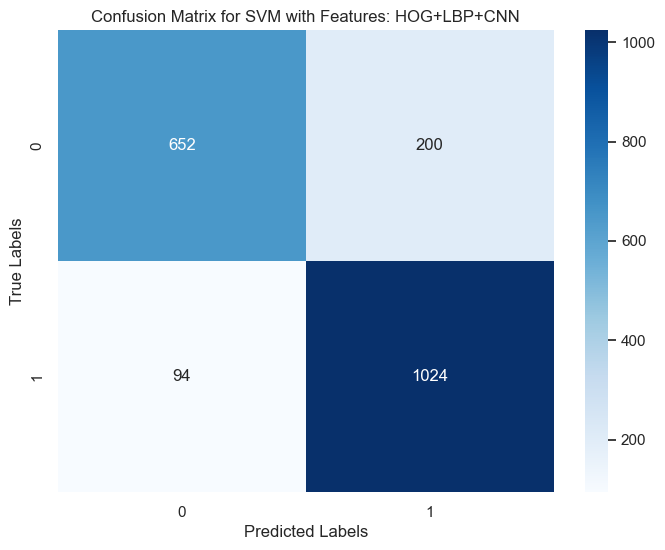

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classifier_name, feature_combination_str):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {classifier_name} with Features: {feature_combination_str}')
    plt.show()

    
# Extract the best-performing classifier and feature combination
best_classifier_name = highest_acc['Classifier']
best_features = highest_acc['Features']

# Recreate the feature set with the best feature combination
best_combined_features = pca_transformed_features[best_features]

# Normalize the features again
scaler = StandardScaler()
best_combined_features = scaler.fit_transform(best_combined_features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(best_combined_features, y_training, test_size=0.2, random_state=42)

# Initialize the best classifier
best_classifier = classifiers[best_classifier_name]

# Train and predict using the best classifier
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)

# Compute the confusion matrix
best_cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(best_cm, best_classifier_name, best_features)
   


